<a href="https://colab.research.google.com/github/bhusserl-davis/ECS171-Group1-Project/blob/main/project_word2Vec_oversample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
# Download Needed Packages
import sys
!{sys.executable} -m pip install -q pandas
!{sys.executable} -m pip install -q nltk
!{sys.executable} -m pip install -q sklearn
!{sys.executable} -m pip install -q wordcloud==1.8.1
!{sys.executable} -m pip install -q gensim==3.8.3
!{sys.executable} -m pip install -q keras
!{sys.executable} -m pip install -q numpy
!{sys.executable} -m pip install -q matplotlib

     |████████████████████████████████| 371 kB 35.3 MB/s 
     |████████████████████████████████| 24.2 MB 1.4 MB/s 


In [ ]:
# Import needed libraries and download needed data
import string
import pandas as pd
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
nltk.download('punkt', quiet=True)
from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud

## Data Exploration

In [ ]:
# Import Data
df = pd.read_csv("./fake_job_postings.csv")
print(f'{df.shape[0]} observations, {df.shape[1]} features')
display(df.head(5))

17880 observations, 18 features


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [ ]:
# Print count of NaNs and type of each column
print("Column\t\t    NaNs   Type")
for column in df.columns:
    print(f'{column.ljust(20)}{str(df[column].isna().sum()).ljust(7)}{df[column].dtype}')

Column		    NaNs   Type
job_id              0      int64
title               0      object
location            346    object
department          11547  object
salary_range        15012  object
company_profile     3308   object
description         1      object
requirements        2695   object
benefits            7210   object
telecommuting       0      int64
has_company_logo    0      int64
has_questions       0      int64
employment_type     3471   object
required_experience 7050   object
required_education  8105   object
industry            4903   object
function            6455   object
fraudulent          0      int64


In [ ]:
#Replacing NAN Values
new_df = df.copy()
NAN_Cols=[
    "location","department","salary_range",
    "company_profile","description","requirements",
    "benefits","employment_type","required_experience",
    "required_experience","required_education","industry","function"
]
print("Column\t\t       NaNs")
for i in NAN_Cols:
    new_df[i].fillna("",inplace=True)
print(new_df.isnull().sum())

Column		       NaNs
job_id                 0
title                  0
location               0
department             0
salary_range           0
company_profile        0
description            0
requirements           0
benefits               0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
dtype: int64


In [ ]:
# Get numeric columns unique values
numeric_atts = ['job_id', 'telecommuting', 'has_company_logo', 'has_questions', 'fraudulent']
for column in numeric_atts:
    print(f'{column}: {new_df[column].unique()}')

job_id: [    1     2     3 ... 17878 17879 17880]
telecommuting: [0 1]
has_company_logo: [1 0]
has_questions: [0 1]
fraudulent: [0 1]


In [ ]:
new_df[:5]

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,Other,Internship,,,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,1,0,,,,,,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",,,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


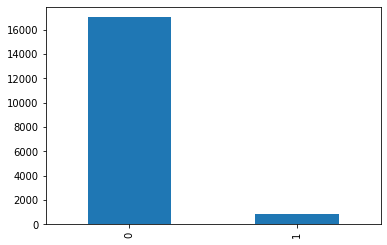

In [ ]:
new_df['fraudulent'].value_counts().plot.bar()

## Preprocessing

### covert string to word token

In [ ]:
# Convert Everything to lowercase
new_df = new_df.applymap(lambda s: s.lower() if type(s) == str else s)
display(new_df.head(5))

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,marketing intern,us ny new york,marketing,,we re food52 and we ve created a groundbreaki...,food52 a fast growing james beard award winn...,experience with content management systems a m...,,0,1,0,other,internship,,,marketing,0
1,2,customer service cloud video production,nz auckland,success,,90 seconds the worlds cloud video production ...,organised focused vibrant awesome do you...,what we expect from you your key responsibilit...,what you will get from usthrough being part of...,0,1,0,full time,not applicable,,marketing and advertising,customer service,0
2,3,commissioning machinery assistant cma,us ia wever,,,valor services provides workforce solutions th...,our client located in houston is actively se...,implement pre commissioning and commissioning ...,,0,1,0,,,,,,0
3,4,account executive washington dc,us dc washington,sales,,our passion for improving quality of life thro...,the company esri – environmental systems rese...,education bachelor’s or master’s in gis busi...,our culture is anything but corporate—we have ...,0,1,0,full time,mid senior level,bachelor s degree,computer software,sales,0
4,5,bill review manager,us fl fort worth,,,spotsource solutions llc is a global human cap...,job title itemization review managerlocation ...,qualifications rn license in the state of texa...,full benefits offered,0,1,1,full time,mid senior level,bachelor s degree,hospital health care,health care provider,0


In [ ]:
# Remove Punctuation
punc_list = list(string.punctuation)
def remove_punctuation(text, punct_list):
    for punc in punct_list:
        if punc in text:
            text = text.replace(punc, ' ')
    return text

new_df = new_df.applymap(lambda s: remove_punctuation(s, punc_list) if type(s) == str else s)
display(new_df.head(5))

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,marketing intern,us ny new york,marketing,,we re food52 and we ve created a groundbreaki...,food52 a fast growing james beard award winn...,experience with content management systems a m...,,0,1,0,other,internship,,,marketing,0
1,2,customer service cloud video production,nz auckland,success,,90 seconds the worlds cloud video production ...,organised focused vibrant awesome do you...,what we expect from you your key responsibilit...,what you will get from usthrough being part of...,0,1,0,full time,not applicable,,marketing and advertising,customer service,0
2,3,commissioning machinery assistant cma,us ia wever,,,valor services provides workforce solutions th...,our client located in houston is actively se...,implement pre commissioning and commissioning ...,,0,1,0,,,,,,0
3,4,account executive washington dc,us dc washington,sales,,our passion for improving quality of life thro...,the company esri – environmental systems rese...,education bachelor’s or master’s in gis busi...,our culture is anything but corporate—we have ...,0,1,0,full time,mid senior level,bachelor s degree,computer software,sales,0
4,5,bill review manager,us fl fort worth,,,spotsource solutions llc is a global human cap...,job title itemization review managerlocation ...,qualifications rn license in the state of texa...,full benefits offered,0,1,1,full time,mid senior level,bachelor s degree,hospital health care,health care provider,0


In [ ]:
# Tokenize each text column
token_df = new_df.copy()
for column in new_df.columns:
    token_df[column] = new_df[column].apply(lambda s: word_tokenize(s) if type(s) == str else s)
display(token_df.head(5))

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,"[marketing, intern]","[us, ny, new, york]",[marketing],[],"[we, re, food52, and, we, ve, created, a, grou...","[food52, a, fast, growing, james, beard, award...","[experience, with, content, management, system...",[],0,1,0,[other],[internship],[],[],[marketing],0
1,2,"[customer, service, cloud, video, production]","[nz, auckland]",[success],[],"[90, seconds, the, worlds, cloud, video, produ...","[organised, focused, vibrant, awesome, do, you...","[what, we, expect, from, you, your, key, respo...","[what, you, will, get, from, usthrough, being,...",0,1,0,"[full, time]","[not, applicable]",[],"[marketing, and, advertising]","[customer, service]",0
2,3,"[commissioning, machinery, assistant, cma]","[us, ia, wever]",[],[],"[valor, services, provides, workforce, solutio...","[our, client, located, in, houston, is, active...","[implement, pre, commissioning, and, commissio...",[],0,1,0,[],[],[],[],[],0
3,4,"[account, executive, washington, dc]","[us, dc, washington]",[sales],[],"[our, passion, for, improving, quality, of, li...","[the, company, esri, –, environmental, systems...","[education, bachelor, ’, s, or, master, ’, s, ...","[our, culture, is, anything, but, corporate—we...",0,1,0,"[full, time]","[mid, senior, level]","[bachelor, s, degree]","[computer, software]",[sales],0
4,5,"[bill, review, manager]","[us, fl, fort, worth]",[],[],"[spotsource, solutions, llc, is, a, global, hu...","[job, title, itemization, review, managerlocat...","[qualifications, rn, license, in, the, state, ...","[full, benefits, offered]",0,1,1,"[full, time]","[mid, senior, level]","[bachelor, s, degree]","[hospital, health, care]","[health, care, provider]",0


### tokenizer 

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(token_df['description'])

X = tokenizer.texts_to_sequences(token_df['description'])

In [ ]:
X[0][:10]

[3025, 5, 149, 96, 5426, 7320, 808, 759, 173, 547]

In [ ]:
word_index = tokenizer.word_index
for word, num in word_index.items():
    print(f"{word} -> {num}")
    if num == 10:
        break    

and -> 1
the -> 2
to -> 3
of -> 4
a -> 5
in -> 6
for -> 7
with -> 8
you -> 9
our -> 10


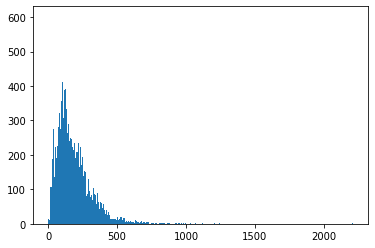

In [ ]:
import matplotlib.pyplot as plt
plt.hist([len(x) for x in X], bins=500)
plt.show()

In [ ]:
import numpy as np
nos = np.array([len(x) for x in X])
len(nos[nos  < 700])


17772

In [ ]:
#Lets keep all descriptions to 700, add padding to descriptions with less than 700 words and truncating long ones
maxlen = 700 

#Making all descriptions of size maxlen defined above
X = pad_sequences(X, maxlen=maxlen)

In [ ]:
#all descriptions has 700 words (in numerical form now). If they had less words, they have been padded with 0
# 0 is not associated to any word, as mapping of words started from 1
# 0 will also be used later, if unknows word is encountered in test set
len(X[0])

700

In [ ]:
# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
y = df['fraudulent']

### oversample

In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
oversample = RandomOverSampler(sampling_strategy='minority')

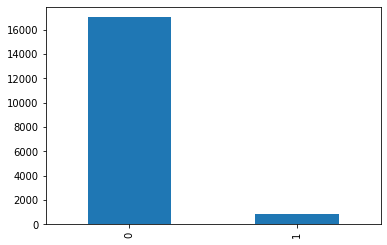

In [ ]:
y.value_counts().plot.bar()

In [ ]:
X_over, y_over = oversample.fit_resample(X, y)

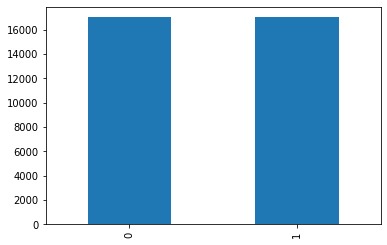

In [ ]:
y_over.value_counts().plot.bar()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over)

## Model Training

### model with no embedding layer

In [ ]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
#LSTM 
model.add(LSTM(units=128,input_shape=(700, 1)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train, y_train, validation_split=0.3, epochs=6)

Epoch 1/6
559/559 [==============================] - 26s 35ms/step - loss: 0.6428 - acc: 0.6157 - val_loss: 0.6137 - val_acc: 0.6637
Epoch 2/6
559/559 [==============================] - 19s 34ms/step - loss: 0.5330 - acc: 0.7335 - val_loss: 0.4929 - val_acc: 0.7611
Epoch 3/6
559/559 [==============================] - 20s 36ms/step - loss: 0.4421 - acc: 0.7923 - val_loss: 0.3802 - val_acc: 0.8181
Epoch 4/6
559/559 [==============================] - 19s 33ms/step - loss: 0.3520 - acc: 0.8425 - val_loss: 0.3071 - val_acc: 0.8639
Epoch 5/6
559/559 [==============================] - 19s 34ms/step - loss: 0.2732 - acc: 0.8838 - val_loss: 0.2598 - val_acc: 0.8915
Epoch 6/6
559/559 [==============================] - 19s 35ms/step - loss: 0.2253 - acc: 0.9099 - val_loss: 0.2623 - val_acc: 0.8913


In [ ]:
y_pred = (model.predict(X_test) >= 0.5).astype("int")

266/266 [==============================] - 4s 12ms/step


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.81      0.88      4231
           1       0.84      0.97      0.90      4276

    accuracy                           0.89      8507
   macro avg       0.90      0.89      0.89      8507
weighted avg       0.90      0.89      0.89      8507



### model with word2Vec embedding layer

In [ ]:
EMBEDDING_DIM = 100

#### word2vec

In [ ]:
import gensim

In [ ]:
sentence = token_df['description']

In [ ]:
print(type(sentence))
print(sentence.shape)
print(sentence)

<class 'pandas.core.series.Series'>
(17880,)
0        [food52, a, fast, growing, james, beard, award...
1        [organised, focused, vibrant, awesome, do, you...
2        [our, client, located, in, houston, is, active...
3        [the, company, esri, –, environmental, systems...
4        [job, title, itemization, review, managerlocat...
                               ...                        
17875    [just, in, case, this, is, the, first, time, y...
17876    [the, payroll, accountant, will, focus, primar...
17877    [experienced, project, cost, control, staff, e...
17878    [nemsia, studios, is, looking, for, an, experi...
17879    [who, are, we, vend, is, an, award, winning, w...
Name: description, Length: 17880, dtype: object


In [ ]:
sentence[1][:5]

['organised', 'focused', 'vibrant', 'awesome', 'do']

In [ ]:
'reproducing' in sentence[0]

True

In [ ]:
# initialize a model
w2v_model = gensim.models.Word2Vec(sentence, size=100, min_count=1)

In [ ]:
print(w2v_model.wv["reproducing"])

[-0.06625532  0.04524589 -0.03366049  0.01755913  0.04502811 -0.01503113
  0.01807251  0.02655526  0.0363437   0.08731454 -0.03499019  0.02292538
  0.05309565 -0.05309085 -0.02968935  0.09621846 -0.05545317 -0.04675927
  0.00353777 -0.07233127  0.00562891  0.10943453  0.06045988  0.13618515
  0.00553672  0.01788815 -0.01238731  0.01973127  0.06087051 -0.10111095
 -0.02010658  0.04912155 -0.11441392  0.07140998  0.04471433  0.02614341
 -0.02573266 -0.00221741  0.11200687  0.13781285  0.05415043  0.01711266
  0.07677389 -0.05388825  0.04543069  0.00969373 -0.00155271  0.07666709
  0.0465457   0.02424619  0.01838778  0.02179661  0.09240932 -0.00903666
  0.00017544  0.06650877  0.03642031 -0.00169821  0.02162958 -0.07016738
 -0.00240001 -0.01771811 -0.03707488  0.10933284  0.02636681  0.11490256
 -0.04911173 -0.03471068  0.00866102  0.00742512  0.00858525 -0.0943966
  0.009151    0.08969795 -0.08739194  0.05771724  0.03733559  0.04338844
  0.1017267  -0.03657389  0.10618334 -0.01236116 -0.

In [ ]:
def most_similar(w2v_model, words, topn=10):
    similar_df = pd.DataFrame()
    for word in words:
        try:
            similar_words = pd.DataFrame(w2v_model.wv.most_similar(word, topn=topn), columns=[word, 'cos'])
            similar_df = pd.concat([similar_df, similar_words], axis=1)
        except:
            print(word, "not found in Word2Vec model!")
    return similar_df

In [ ]:
most_similar(w2v_model,['our','title','client','company'])

,our,cos,title,cos,client,cos,company,cos
0,its,0.674108,jr,0.621145,customer,0.669217,organization,0.647618
1,their,0.533531,assistantdescriptionan,0.604257,clients,0.615988,organisation,0.619727
2,the,0.505009,descriptionadministrative,0.597986,achieved·,0.537820,firm,0.543810
3,presenceworking,0.463249,premiumsact,0.583896,customers,0.494937,agency,0.520409
4,global,0.414039,paralegal,0.573212,strategic,0.490292,department,0.494056
5,success,0.410773,2048job,0.563640,stakeholder,0.478504,industry,0.459654
6,improvementsevangelize,0.406410,analystlocation,0.555974,companiesbuilding,0.470133,companytfe,0.448281
7,your,0.399526,description,0.555558,perfiles,0.465613,startup,0.442648
8,together,0.393802,escrow,0.553635,upgradeswork,0.464522,group,0.424358
9,marketcommunicate,0.392631,summary,0.551896,counted,0.450940,networkone,0.423874


#### create embedding_vectors

In [ ]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model.wv[word]
    return weight_matrix

In [ ]:
print(type(word_index))
print(word_index["reproducing"])

<class 'dict'>
15409


In [ ]:
#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, word_index)

In [ ]:
w2v_model.wv['and']

array([ 0.68162936,  0.7915604 ,  0.22148693, -2.1904106 ,  0.46871662,
       -0.6681396 , -0.1115028 ,  1.2353356 ,  0.39056507,  1.6800199 ,
       -0.08013184, -0.1183731 ,  0.8423637 ,  0.45448062,  0.22996792,
       -0.8708475 ,  0.0461343 , -0.07854148, -0.7116059 ,  1.5691217 ,
       -1.7473004 ,  1.6154784 ,  1.2115083 , -0.31688178,  0.1902195 ,
       -2.5152345 ,  0.30872804,  2.439953  ,  0.43447894,  1.6609881 ,
        0.98227906, -0.75287396, -0.00329624,  0.20104164,  0.6556965 ,
        0.28810757,  0.03439233, -0.60846674,  0.4609818 ,  0.4798694 ,
        0.3653384 ,  0.1549128 ,  0.95546263, -1.0327297 , -0.04061998,
        0.26109025,  1.6393111 ,  0.15592681, -0.17485055, -0.33660522,
        0.78651726, -0.23558982,  0.13451265, -0.24725299, -0.34620854,
        0.5669992 ,  0.1324819 , -0.7757102 ,  0.7084115 ,  0.04469537,
        1.1942395 , -1.8247885 ,  0.05949418, -1.0389054 ,  0.67549604,
        0.4502798 ,  2.119836  ,  0.30318207,  0.0350472 ,  0.03

In [ ]:
embedding_vectors[1][:100]

array([ 0.68162936,  0.79156041,  0.22148693, -2.19041061,  0.46871662,
       -0.66813958, -0.1115028 ,  1.23533559,  0.39056507,  1.68001986,
       -0.08013184, -0.1183731 ,  0.84236372,  0.45448062,  0.22996792,
       -0.87084752,  0.0461343 , -0.07854148, -0.71160591,  1.56912172,
       -1.74730039,  1.6154784 ,  1.21150827, -0.31688178,  0.19021951,
       -2.51523447,  0.30872804,  2.43995309,  0.43447894,  1.66098809,
        0.98227906, -0.75287396, -0.00329624,  0.20104164,  0.65569651,
        0.28810757,  0.03439233, -0.60846674,  0.46098179,  0.4798694 ,
        0.36533839,  0.1549128 ,  0.95546263, -1.03272974, -0.04061998,
        0.26109025,  1.63931108,  0.15592681, -0.17485055, -0.33660522,
        0.78651726, -0.23558982,  0.13451265, -0.24725299, -0.34620854,
        0.5669992 ,  0.1324819 , -0.77571023,  0.70841151,  0.04469537,
        1.1942395 , -1.82478845,  0.05949418, -1.03890538,  0.67549604,
        0.4502798 ,  2.11983609,  0.30318207,  0.0350472 ,  0.03

In [ ]:
embedding_vectors[1].size

100

#### add embedding into model

In [ ]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 700, 100)          6429900   
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 6,547,277
Trainable params: 117,377
Non-trainable params: 6,429,900
_________________________________________________________________


In [ ]:
model.fit(X_train, y_train, validation_split=0.3, epochs=6)

Epoch 1/6
559/559 [==============================] - 23s 38ms/step - loss: 0.3072 - acc: 0.8615 - val_loss: 0.1484 - val_acc: 0.9478
Epoch 2/6
559/559 [==============================] - 20s 36ms/step - loss: 0.1225 - acc: 0.9596 - val_loss: 0.0779 - val_acc: 0.9730
Epoch 3/6
559/559 [==============================] - 21s 37ms/step - loss: 0.0375 - acc: 0.9888 - val_loss: 0.0748 - val_acc: 0.9740
Epoch 4/6
559/559 [==============================] - 20s 36ms/step - loss: 0.0202 - acc: 0.9948 - val_loss: 0.0440 - val_acc: 0.9849
Epoch 5/6
559/559 [==============================] - 20s 37ms/step - loss: 0.0204 - acc: 0.9937 - val_loss: 0.0275 - val_acc: 0.9931
Epoch 6/6
559/559 [==============================] - 21s 37ms/step - loss: 0.0102 - acc: 0.9970 - val_loss: 0.0383 - val_acc: 0.9877


In [ ]:
y_pred = (model.predict(X_test) >= 0.5).astype("int")

266/266 [==============================] - 4s 13ms/step


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99      4231
           1       0.97      1.00      0.99      4276

    accuracy                           0.99      8507
   macro avg       0.99      0.99      0.99      8507
weighted avg       0.99      0.99      0.99      8507

